In [1]:
# pip install imbalanced-learn

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from IPython.display import display, HTML



In [3]:
# Load data
data = pd.read_csv('augmented_file_50x.csv')

In [4]:
data['label'].value_counts()

label
rice           5000
maize          5000
jute           5000
cotton         5000
coconut        5000
papaya         5000
orange         5000
apple          5000
muskmelon      5000
watermelon     5000
grapes         5000
mango          5000
banana         5000
pomegranate    5000
lentil         5000
blackgram      5000
mungbean       5000
mothbeans      5000
pigeonpeas     5000
kidneybeans    5000
chickpea       5000
coffee         5000
Name: count, dtype: int64

In [5]:
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,50.551818,53.362727,48.149091,25.616123,71.481866,6.469327,103.463667
std,36.909110,32.978535,50.636649,5.062866,22.258952,0.775523,54.946209
min,-0.000000,5.000000,5.000000,8.693522,14.132941,3.382286,20.100759
25%,21.000000,28.000000,20.000000,22.761534,60.252213,5.970163,64.530224
50%,37.000000,51.000000,32.000000,25.595386,80.475355,6.424988,94.870159
75%,84.250000,68.000000,49.000000,28.558985,89.956770,6.920756,124.296449
max,140.000000,145.000000,205.000000,43.800557,100.124082,10.040529,298.696561


<Axes: xlabel='rainfall', ylabel='Density'>

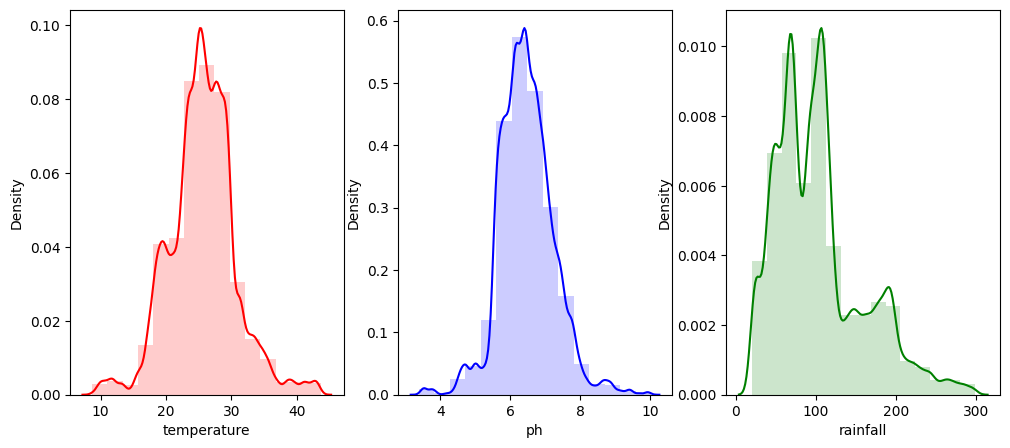

In [6]:
# Visualizing the data distribution between temperature, ph and rainfall

plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.distplot(data['temperature'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['ph'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['rainfall'],color="green",bins=15,hist_kws={'alpha':0.2})


<Axes: xlabel='K', ylabel='Density'>

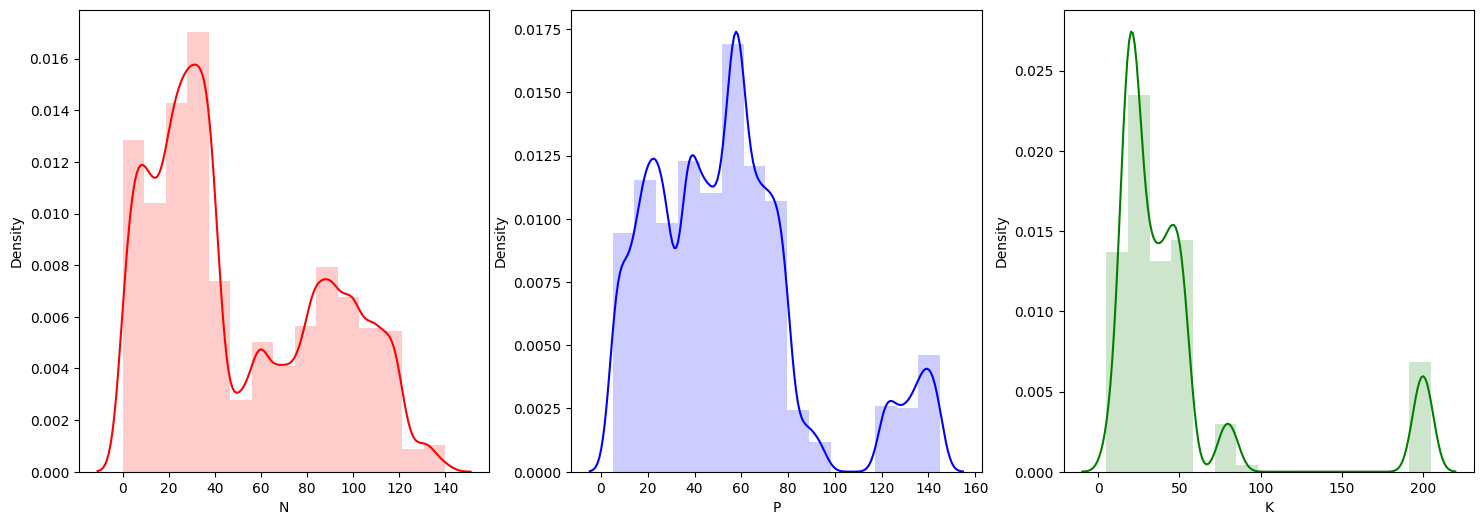

In [7]:
# Visualizing the data distribution between N, P, and K

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.distplot(data['N'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['P'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['K'],color="green",bins=15,hist_kws={'alpha':0.2})

In [8]:
# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Lists to collect split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# Split each label's data separately
labels = y.unique()
for label in labels:
    X_label = X[y == label]
    y_label = y[y == label]
    
    X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
        X_label, y_label, test_size=0.20, random_state=0)
    
    X_train_list.append(X_train_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_test_list.append(y_test_label)

# Concatenate splits
X_train = pd.concat(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))



Training set size: 88000
Testing set size: 22000


Cross-validated accuracy scores for each fold: [0.95136364 0.9475     0.95056818 0.94897727 0.94863636 0.94897727
 0.95261364 0.95284091 0.95352273 0.95      ]
Mean CV Accuracy: 0.9504999999999999
Standard Deviation of CV Accuracy: 0.0019286069566888055
Calibrated Random Forest Validation accuracy: 0.9822727272727273
Calibrated Random Forest Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       504
      banana       1.00      1.00      1.00       514
   blackgram       0.92      0.99      0.96       522
    chickpea       1.00      1.00      1.00       514
     coconut       1.00      0.96      0.98       499
      coffee       1.00      1.00      1.00       499
      cotton       1.00      1.00      1.00       496
      grapes       1.00      1.00      1.00       496
        jute       0.82      1.00      0.90       474
 kidneybeans       1.00      1.00      1.00       494
      lentil       0.99      0.96     

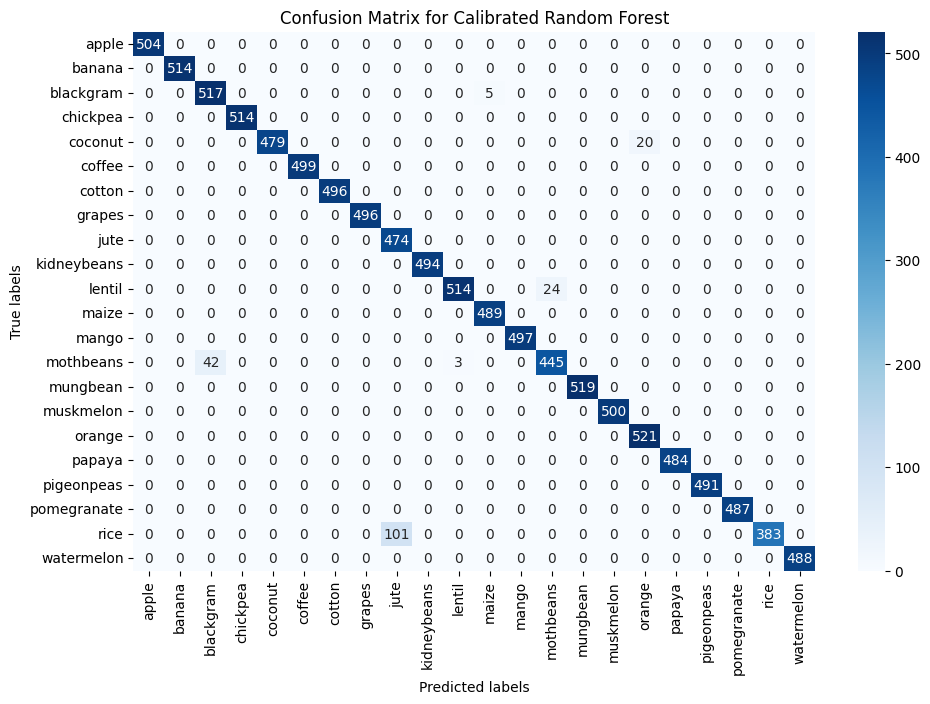

In [9]:

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = under.fit_resample(X_train, y_train)

# Train the Random Forest on the resampled data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_resampled, y_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores = cross_val_score(clf_rf, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Split the test set further into calibration and validation sets
X_calibrate, X_validate, y_calibrate, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Calibrate the classifier on the calibration set
calibrated_rf = CalibratedClassifierCV(clf_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_calibrate, y_calibrate)

# Predict on the validation set using the calibrated RF
y_pred_calibrated = calibrated_rf.predict(X_validate)
accuracy_score_rf = accuracy_score(y_validate, y_pred_calibrated)

print("Calibrated Random Forest Validation accuracy:", accuracy_score_rf)
print("Calibrated Random Forest Classification Report:")
print(classification_report(y_validate, y_pred_calibrated))

# Compute the confusion matrix for calibrated RF
conf_mat_calibrated = confusion_matrix(y_validate, y_pred_calibrated)
class_labels = np.unique(y_validate)

# Plot using Seaborn for calibrated RF
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_calibrated, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Calibrated Random Forest')
plt.show()





Cross-validated accuracy scores for each fold (KNN): [0.95579545 0.95409091 0.95556818 0.95681818 0.95875    0.95545455
 0.95636364 0.95806818 0.95806818 0.95738636]
Mean CV Accuracy (KNN): 0.9566363636363636
Standard Deviation of CV Accuracy (KNN): 0.001377017678154631
K-nearest Neighbors Test accuracy: 0.9616363636363636
K-nearest Neighbors Classification Report:
              precision    recall  f1-score   support

       apple       0.92      1.00      0.96      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.90      0.99      0.95      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.98      1.00      0.99      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      0.92      0.96      1000
        jute       0.79      1.00      0.88      1000
 kidneybeans       0.93      1.00      0.96      1000
      lentil       0.96      0.97    

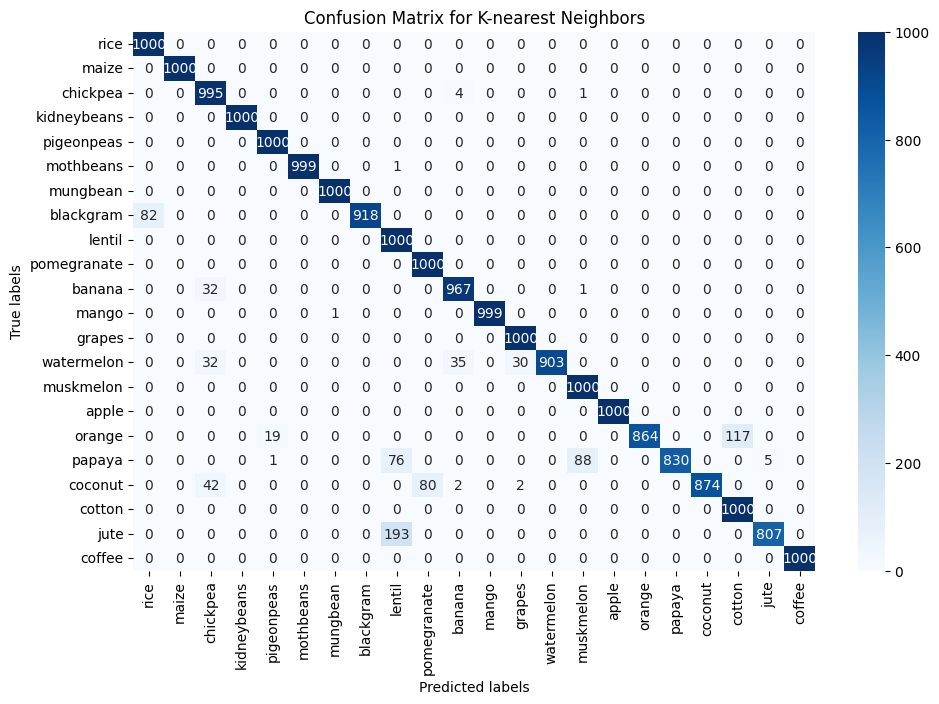

In [10]:

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

# Apply the undersampling strategy
X_train_resampled, y_train_resampled = under.fit_resample(X_train_scaled, y_train)

# Define the K-nearest neighbors (KNN) classifier with adjusted parameters
clf_knn = KNeighborsClassifier(n_neighbors=5001, weights='distance', algorithm='auto', p=2)

# Fit the KNN model with resampled training data
clf_knn.fit(X_train_resampled, y_train_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores_knn = cross_val_score(clf_knn, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold (KNN):", cv_scores_knn)
print("Mean CV Accuracy (KNN):", cv_scores_knn.mean())
print("Standard Deviation of CV Accuracy (KNN):", cv_scores_knn.std())

# Predict using the KNN model on the scaled test set
y_pred_knn = clf_knn.predict(X_test_scaled)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)

print("K-nearest Neighbors Test accuracy:", accuracy_score_knn)
print("K-nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Compute the confusion matrix
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-nearest Neighbors')
plt.show()



Cross-validated accuracy scores for each fold: [0.95977273 0.96079545 0.95681818 0.9575     0.95522727 0.96034091
 0.95988636 0.95681818 0.95659091 0.96045455]
Mean CV Accuracy: 0.9584204545454545
Standard Deviation of CV Accuracy: 0.0019227393616641295
Naive Bayes Test accuracy: 0.9548181818181818
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.88      0.97      0.92      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.91      0.95      1000
      coffee       1.00      0.99      0.99      1000
      cotton       0.93      1.00      0.97      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.75      1.00      0.85      1000
 kidneybeans       0.89      1.00      0.94      1000
      lentil       0.88      1.00      0.94      1000
       maize       1.00      0.90      0.95      10

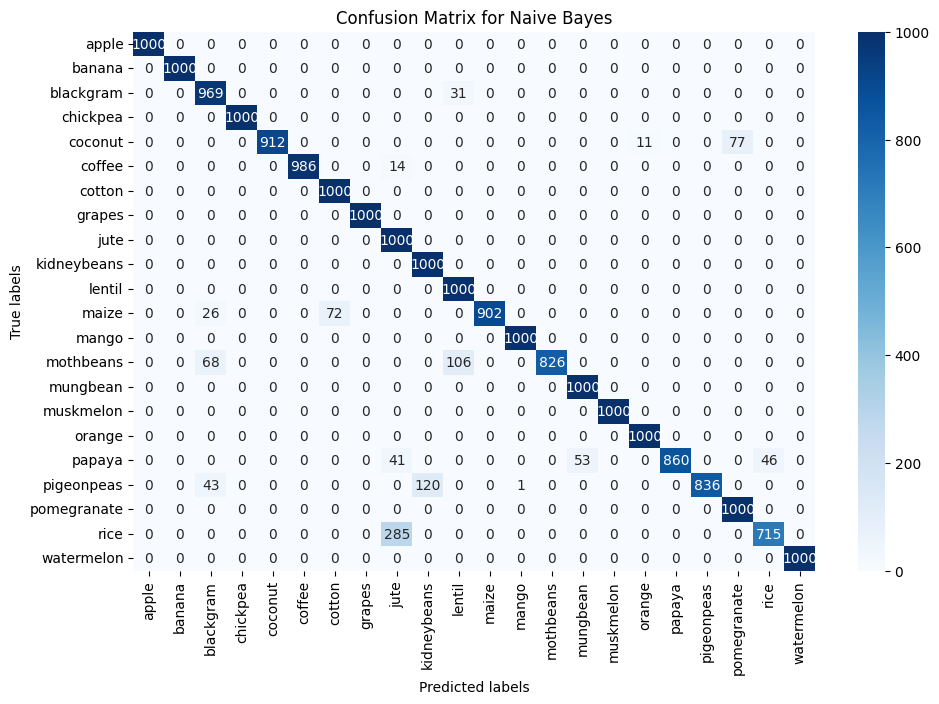

In [11]:

# Set up the RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Set var_smoothing parameter for regularization; you can adjust the value as needed
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 10-fold cross-validation on undersampled data
cv_scores = cross_val_score(clf_nb, X_train_under, y_train_under, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the clf_nb with the undersampled training data and predict for the test set
clf_nb.fit(X_train_under, y_train_under)
y_pred_nb = clf_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

# Print the Naive Bayes Classification Report
print("Naive Bayes Test accuracy:", accuracy_score_nb)
print(classification_report(y_test, y_pred_nb))

# Compute the confusion matrix
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()



In [12]:
# # Use pipeline to ensure that the data is scaled before applying SVM
# clf_svm = make_pipeline(
#     StandardScaler(), 
#     SVC(gamma = 0.1, C=0.01, random_state=0) # Updated kernel and gamma
# )

# # Using the pipeline to fit and predict ensures that scaling is applied in each step of CV and prediction.
# clf_svm.fit(X_train_temp, y_train_temp)

# # Perform 5-fold cross-validation
# cv_scores_svm = cross_val_score(clf_svm, X, y, cv=5, scoring='accuracy')

# # Print out the scores for each fold and average accuracy for SVM
# print("Cross-validated accuracy scores for each fold (SVM):", cv_scores_svm)
# print("Mean CV Accuracy (SVM):", cv_scores_svm.mean())
# print("Standard Deviation of CV Accuracy (SVM):", cv_scores_svm.std())

# y_pred_svm = clf_svm.predict(X_test)
# accuracy_score_svm = accuracy_score(y_test, y_pred_svm)

# print("SVM Test accuracy:", accuracy_score_svm)
# print("SVM Classification Report:")
# print(classification_report(y_test, y_pred_svm))


# # Compute the confusion matrix
# conf_mat_svm = confusion_matrix(y_test, y_pred_rf)

# # Extract unique class labels
# class_labels = data['label'].unique()

# # Plot using Seaborn
# plt.figure(figsize=(10,7))
# sns.heatmap(conf_mat_svm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted labels')
# plt.ylabel('True labels')
# plt.title('Confusion Matrix for SVM')
# plt.show()

# # # Compute macro-average ROC curve and ROC area for multi-class task for SVM
# # fpr_svm = dict()
# # tpr_svm = dict()
# # roc_auc_svm = dict()

# # for i in range(n_classes):
# #     fpr_svm[i], tpr_svm[i], _ = roc_curve(y_bin_test[:, i], y_bin_pred_svm[:, i])
# #     roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

# # all_fpr_svm = np.unique(np.concatenate([fpr_svm[i] for i in range(n_classes)]))
# # mean_tpr_svm = np.zeros_like(all_fpr_svm)
# # for i in range(n_classes):
# #     mean_tpr_svm += np.interp(all_fpr_svm, fpr_svm[i], tpr_svm[i])
# # mean_tpr_svm /= n_classes

# # fpr_svm["macro"] = all_fpr_svm
# # tpr_svm["macro"] = mean_tpr_svm
# # roc_auc_svm["macro"] = auc(fpr_svm["macro"], tpr_svm["macro"])

# # print("SVM Macro-average of ROC curve:", roc_auc_svm["macro"])

# # # Plot the ROC curve for SVM
# # plt.figure()
# # plt.plot(fpr_svm["macro"], tpr_svm["macro"],
# #          label='macro-average ROC curve (area = {0:0.2f})'
# #                ''.format(roc_auc_svm["macro"]),
# #          color='green', linestyle=':', linewidth=4)
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('Receiver Operating Characteristic Curve for SVM')
# # plt.legend(loc="lower right")
# # plt.show()

Cross-validated accuracy scores for each fold: [0.92436364 0.925      0.92509091 0.92518182 0.92509091 0.926
 0.926      0.92536364 0.92527273 0.92545455]
Mean CV Accuracy: 0.9252818181818183
Standard Deviation of CV Accuracy: 0.0004553629013224862
Logistic Regression Test accuracy: 0.9189090909090909
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.79      0.91      0.85      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.90      1.00      0.95      1000
      coffee       0.99      1.00      0.99      1000
      cotton       0.95      0.98      0.96      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.87      0.74      0.80      1000
 kidneybeans       0.90      0.99      0.95      1000
      lentil       0.88      0.88      0.88      1000
     

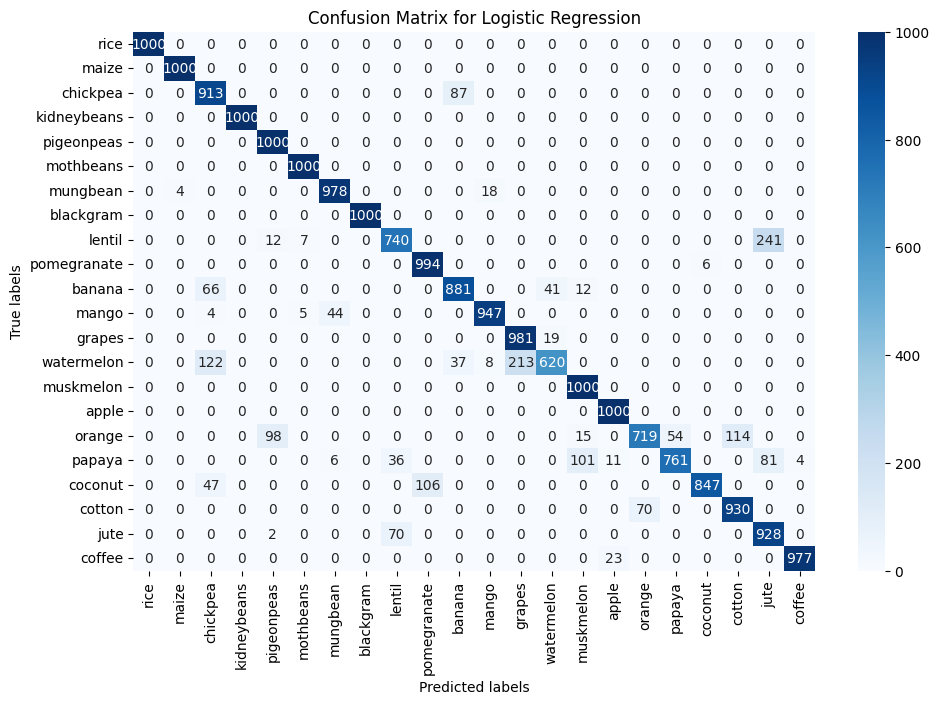

In [13]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Adjusted the dataset name here
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)  
clf_lr.fit(X_train_scaled, y_train)  # Adjusted the dataset names here

# Remember to scale the entire dataset for cross-validation
X_scaled = scaler.transform(X)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf_lr, X_scaled, y, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

print("Logistic Regression Test accuracy:", accuracy_score_lr)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Compute the confusion matrix
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')  # Updated the title here
plt.show()


Cross-validated accuracy scores for each fold: [0.96511364 0.96693182 0.97       0.96829545 0.97011364 0.96772727
 0.96159091 0.96806818 0.96193182 0.95920455]
Mean CV Accuracy: 0.9658977272727272
Standard Deviation of CV Accuracy: 0.0035940183604437214
XGBoost Test accuracy: 0.9691363636363637
XGBoost Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.89      0.99      0.94      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.87      0.99      0.93      1000
      coffee       1.00      1.00      1.00      1000
      cotton       0.99      0.99      0.99      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.83      1.00      0.91      1000
 kidneybeans       1.00      1.00      1.00      1000
      lentil       0.93      1.00      0.96      1000
       maize       0.99 

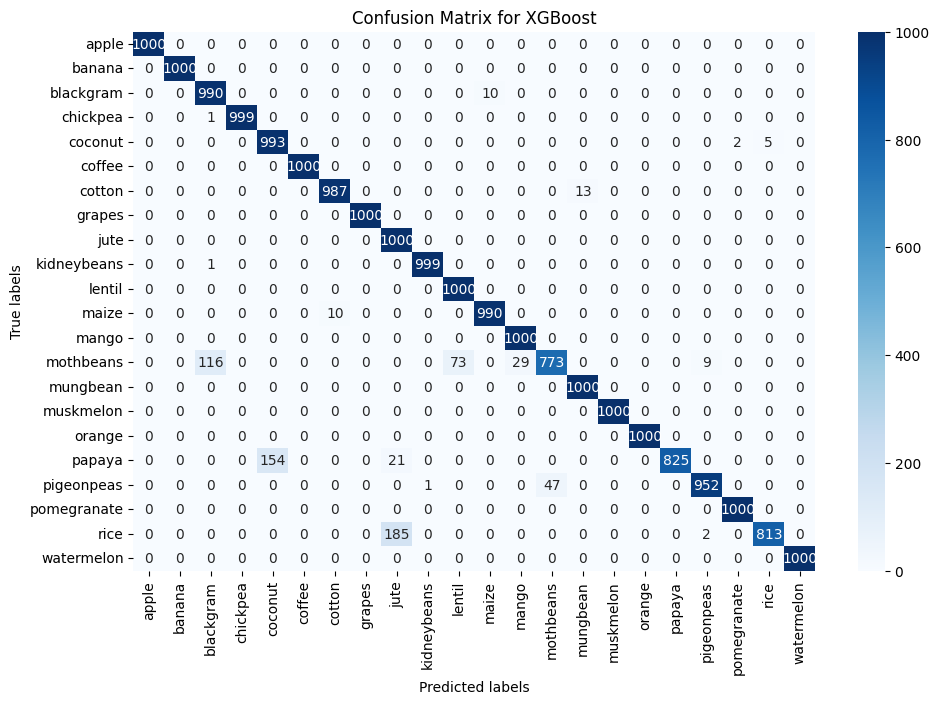

In [31]:
# Convert string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the XGBoost classifier with modifications
clf_xgb = xgb.XGBClassifier(
    n_estimators=5,
    max_depth=3,
    min_child_weight=5,
    gamma=0.01,
    learning_rate=0.03,
    objective='multi:softmax',
    random_state=0
)

# Fit the model
clf_xgb.fit(X_train, y_train_encoded)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf_xgb, X_train, y_train_encoded, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Decode the predicted labels to original string format
y_pred_xgb = le.inverse_transform(clf_xgb.predict(X_test))

# Use the decoded predicted labels for calculating accuracy and plotting confusion matrix
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost Test accuracy:", accuracy_score_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Extract unique class labels from y_train
class_labels = np.unique(y_train)

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=class_labels)
y_bin_pred_xgb = label_binarize(y_pred_xgb, classes=class_labels)

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


In [32]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
print("KNN:", accuracy_score_knn)
print("Naive Bayes Accuracy:", accuracy_score_nb)
# print("SVM Accuracy:", accuracy_score_svm)
print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
print("XGBoost Accuracy:", accuracy_score_xgb)


Random Forest Accuracy: 0.9822727272727273
KNN: 0.9616363636363636
Naive Bayes Accuracy: 0.9548181818181818
Logistic Regression Accuracy (Scaled Data): 0.9189090909090909
XGBoost Accuracy: 0.9691363636363637


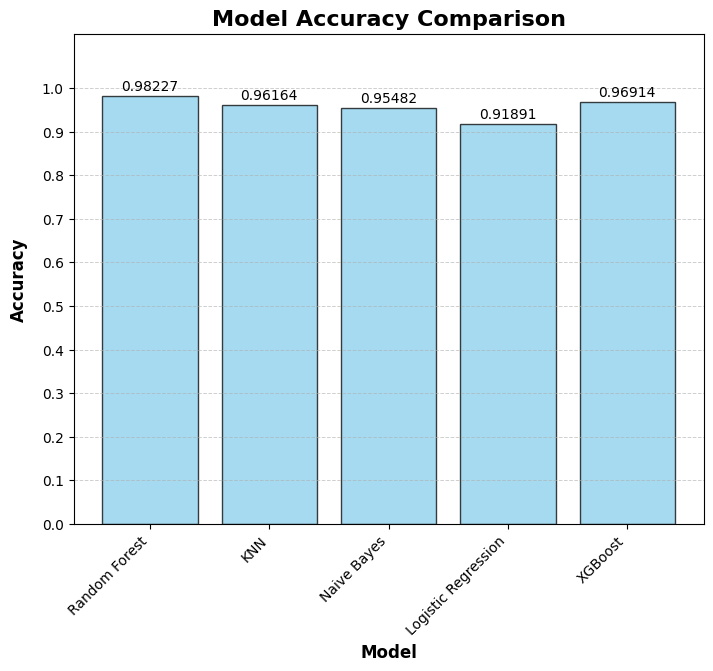

In [33]:
model_names = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'XGBoost'] # Add 'SVM'
accuracies = [accuracy_score_rf, accuracy_score_knn, accuracy_score_nb, accuracy_score_lr, accuracy_score_xgb] # Add ccuracy_score_svm

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Using consistent colors with a slight alpha transparency and edge color
bars = ax.bar(model_names, accuracies, color='skyblue', alpha=0.75, edgecolor='black')

# Adding data labels with 4 decimal places
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, "{:.5f}".format(yval), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10)  # labelpad adds some padding to the ylabel
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.125)  # Added a bit more space at the top for the data labels
ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)], fontsize=10)
ax.set_xticks(range(len(model_names)))

# Adjusting font size of the classifier names
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Reduced font size to 10

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)  # Adding horizontal grid lines

# Adjust the position of the axes to create margins inside the chart
ax.set_position([0.5, 0.5, 0.7, 0.7])  # left, bottom, width, height


plt.show()

**Making Predictions**

Model-wise Predictions:
| Model Name            | Prediction   |
|-----------------------|--------------|
| Random Forest         | mothbeans    |
| KNN                   | apple        |
| Naive Bayes           | mothbeans    |
| Logistic Regression   | papaya       |
| XGBoost               | mothbeans    |


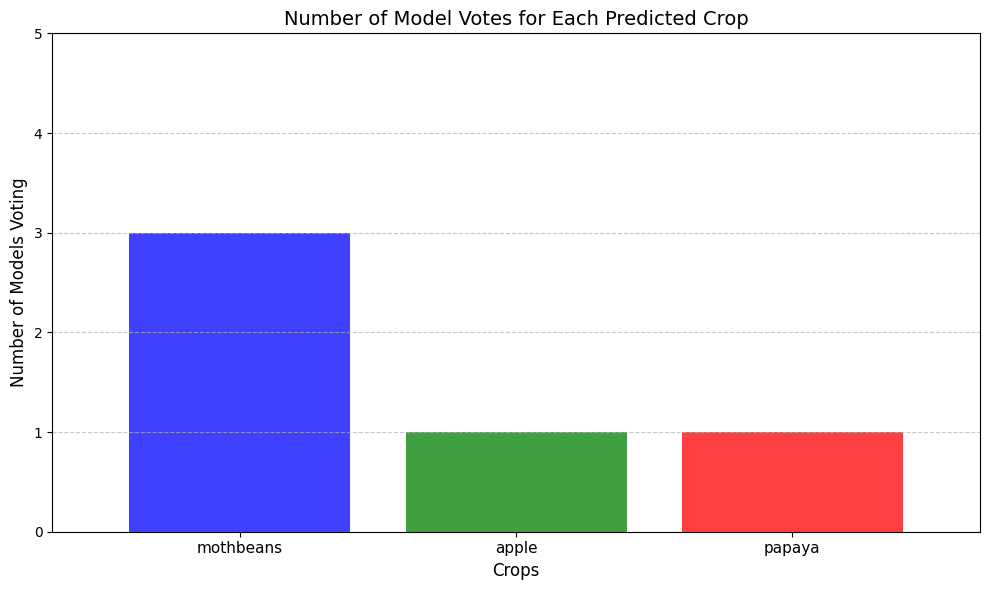


--------------------------------------------------
              ENSEMBLE PREDICTION RESULT      
--------------------------------------------------
| Crop Predicted   | mothbeans                   |
|------------------|-----------------------------|
| Accuracy         | 0.94                        |
| Precision        | 0.93                        |
| Recall           | 0.92                        |
| F1 Score         | 0.93                        |
--------------------------------------------------

Note:
The ensemble prediction is derived from a majority consensus across various models.


In [64]:
# Define the original feature names and input data
original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
data = np.array([[25, 51, 18, 27.77799528, 54.82130787, 9.45949344, 50.28438729]])
data_df = pd.DataFrame(data, columns=original_feature_names)

# List of classifiers
classifiers = {
    "Random Forest": clf_rf,
    "KNN": clf_knn,
    "Naive Bayes": clf_nb,
    "Logistic Regression": clf_lr,
    "XGBoost": clf_xgb,
}

votes = []

# Iterate over classifiers to get their predictions
for clf_name, clf in classifiers.items():
    proba = clf.predict_proba(data_df.values)
    predicted_index = np.argmax(proba)
    
    if clf_name == "XGBoost":
        predicted_label = le.inverse_transform([predicted_index])[0]
    else:
        predicted_label = clf.classes_[predicted_index]
    
    votes.append(predicted_label)

# Ensemble voting
vote_counts = Counter(votes)
most_common_votes = vote_counts.most_common()

if len(most_common_votes) > 1 and most_common_votes[0][1] == most_common_votes[1][1]:
    tied_classes = [vote[0] for vote in most_common_votes if vote[1] == most_common_votes[0][1]]
    ensemble_prediction = tied_classes[0]
else:
    ensemble_prediction = most_common_votes[0][0]

# Get metrics of the ensemble prediction from the model that matches the ensemble result
matching_model = [clf_name for clf_name, predicted_label in zip(classifiers, votes) if predicted_label == ensemble_prediction][0]
ensemble_metrics = model_metrics.get(matching_model, {"Accuracy": "-", "Precision": "-", "Recall": "-", "F1 Score": "-"})


# Tabular Representation of Model-wise Predictions
print("Model-wise Predictions:")
print("| Model Name            | Prediction   |")
print("|-----------------------|--------------|")
for clf_name in classifiers:
    predicted_label = votes[list(classifiers.keys()).index(clf_name)]
    print(f"| {clf_name:<21} | {predicted_label:<12} |")

# Visualization: Histogram of Predictions
plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red', 'cyan', 'purple']
plt.bar(vote_counts.keys(), vote_counts.values(), color=colors, alpha=0.75)
plt.yticks(np.arange(0, 6, 1))
plt.ylim(0, 5)
plt.ylabel('Number of Models Voting', fontsize=12)
plt.xlabel('Crops', fontsize=12)
plt.title('Number of Model Votes for Each Predicted Crop', fontsize=14)
plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(0.1)
plt.tight_layout()
plt.show()

# Tabular Representation of Ensemble Prediction Results
print("\n--------------------------------------------------")
print("              ENSEMBLE PREDICTION RESULT      ")
print("--------------------------------------------------")
print(f"| Crop Predicted   | {ensemble_prediction:<27} |")
print("|------------------|-----------------------------|")
print(f"| Accuracy         | {ensemble_metrics['Accuracy']:<27} |")
print(f"| Precision        | {ensemble_metrics['Precision']:<27} |")
print(f"| Recall           | {ensemble_metrics['Recall']:<27} |")
print(f"| F1 Score         | {ensemble_metrics['F1 Score']:<27} |")
print("--------------------------------------------------")
print("\nNote:")
print("The ensemble prediction is derived from a majority consensus across various models.")
